<div class="alert alert-info">

## **Experiments**

In this notebook we test extracting features from the videos using different feature extractors & with then train a Dense and LSTM network on the extracted features.

</div>

<div class="alert alert-success">

- [ ] Retry experiments but with normalized features or Batch Normalization & more complex networks.
- [ ] Try with YOLO centered key points to the body center.
- [ ] Try with all features + appended optical flow or yolo key points.

</div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import tqdm
import torch
import pickle
import torchvision

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from enum import IntEnum
from matplotlib.lines import Line2D
from sklearn.metrics import confusion_matrix

from video_dataset import VideoDataset
from video_dataset.padder import LastValuePadder
from video_dataset.dataset import VideoShapeComponents
from video_dataset.video import VideoFromVideoFramesDirectory
from video_dataset.preprocessor import extract_frames_from_videos
from video_dataset.annotations import AnnotationsFromSegmentLevelCsvFileAnnotations

from tas_helpers.visualization import SegmentationVisualizer
from tas_helpers.scores import repetition_score, order_variation_score
from tas_helpers.metrics import mean_over_frames, f1_score, edit_distance

from extractors import \
    FeatureExtractor, \
    ResNet3DFeatureExtractor, \
    DinoFeatureExtractor, \
    I3DFeatureExtractor, \
    ClipFeatureExtractor, \
    YoloFeatureExtractor, \
    IJepaFeatureExtractor, \
    S3DKineticsFeatureExtractor, \
    S3DHowTo100MFeatureExtractor, \
    X3DSFeatureExtractor, \
    SlowFastFeatureExtractor, \
    X3DModelType

from cached_dataset import DiskCachedDataset

from utils import LabelEncoderFactory

/Users/nadir/Documents/code/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/nadir/Documents/code/.venv/lib/python3.12/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/Users/nadir/Documents/code/.venv/lib/python3.12/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [3]:
DATASET_PATH = "/Users/nadir/Documents/research-project-dataset"

VIDEOS_DIRECTORY_NAME = "videos"
ANNOTATIONS_DIRECTORY_NAME = "annotations"
VIDEOS_FRAMES_DIRECTORY_NAME = "videos_frames"

ANNOTATED_IDS_FILE_NAME = "annotated_ids.txt"
UNANNOTATED_IDS_FILE_NAME = "unannotated_ids.txt"

TESTING_PERCENTAGE = 0.3

NUMBER_OF_FOLDS = 5

class FeaturesType(IntEnum):
    TEMPORAL = 0
    FRAME_BY_FRAME = 1

FEATURES_EXTRACTORS = [
    {
        "name": "averaged-dino",
        "features-directory-name": "features/averaged-dino-features",
        "extractor": DinoFeatureExtractor(average_pool=True),
        "#frames": 8,
        "type": FeaturesType.TEMPORAL,
    },
    {
        "name": "dino",
        "features-directory-name": "features/dino-features",
        "extractor": DinoFeatureExtractor(average_pool=False),
        "#frames": 8,
        "type": FeaturesType.FRAME_BY_FRAME,
    },
    {
        "name": "resnet-3d",
        "features-directory-name": "features/resnet-3d-features",
        "extractor": ResNet3DFeatureExtractor(),
        "#frames": 8,
        "type": FeaturesType.TEMPORAL,
    },
    {
        "name": "i3d",
        "features-directory-name": "features/i3d-features",
        "extractor": I3DFeatureExtractor(),
        "#frames": 16,
        "type": FeaturesType.TEMPORAL,
    },
    {
        "name": "clip",
        "features-directory-name": "features/clip-features",
        "extractor": ClipFeatureExtractor(average_pool=False),
        "#frames": 8,
        "type": FeaturesType.FRAME_BY_FRAME,
    },
    # {
    #     "name": "averaged-clip",
    #     "features-directory-name": "features/averaged-clip-features",
    #     "extractor": ClipFeatureExtractor(average_pool=True),
    #     "#frames": 8,
    #     "type": FeaturesType.TEMPORAL,
    # },
    # {
    #     "name": "averaged-yolo",
    #     "features-directory-name": "features/averaged-yolo-features",
    #     "extractor": YoloFeatureExtractor(average_pool=True),
    #     "#frames": 8,
    #     type: FeaturesType.TEMPORAL,
    # },
    {
        "name": "x3d-xs",
        "features-directory-name": "features/x3d-xs-features",
        "extractor": X3DSFeatureExtractor(X3DModelType.XS),
        "#frames": 32,
        "type": FeaturesType.TEMPORAL,
    },
    {
        "name": "x3d-s",
        "features-directory-name": "features/x3d-s-features",
        "extractor": X3DSFeatureExtractor(X3DModelType.S),
        "#frames": 32,
        "type": FeaturesType.TEMPORAL,
    },
    {
        "name": "x3d-m",
        "features-directory-name": "features/x3d-m-features",
        "extractor": X3DSFeatureExtractor(X3DModelType.M),
        "#frames": 32,
        "type": FeaturesType.TEMPORAL,
    },
    {
        "name": "yolo",
        "features-directory-name": "features/yolo-features",
        "extractor": YoloFeatureExtractor(average_pool=False),
        "#frames": 8,
        "type": FeaturesType.FRAME_BY_FRAME,
    },
    # {
    #     "name": "averaged-i-jepa",
    #     "features-directory-name": "features/averaged-i-jepa-features",
    #     "extractor": IJepaFeatureExtractor(average_pool=True),
    #     "#frames": 8,
    #     "type": FeaturesType.TEMPORAL,
    # },
    # {
    #     "name": "i-jepa",
    #     "features-directory-name": "features/i-jepa-features",
    #     "extractor": IJepaFeatureExtractor(average_pool=False),
    #     "#frames": 8,
    #     "type": FeaturesType.FRAME_BY_FRAME,
    # },
    {
        "name": "s3d-kinetics",
        "features-directory-name": "features/s3d-kinetics-features",
        "extractor": S3DKineticsFeatureExtractor(),
        "#frames": 16,
        "type": FeaturesType.TEMPORAL,
    },
    {
        "name": "s3d-howto100m",
        "features-directory-name": "features/s3d-howto100m-features",
        "extractor": S3DHowTo100MFeatureExtractor(),
        "#frames": 16,
        "type": FeaturesType.TEMPORAL,
    },
    {
        "name": "slowfast",
        "features-directory-name": "features/slowfast-features",
        "extractor": SlowFastFeatureExtractor(),
        "#frames": 32,
        "type": FeaturesType.TEMPORAL,
    },
]

Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_dinov2_main
/Users/nadir/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/nadir/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/nadir/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_dinov2_main
Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main


[missing-keys]: <All keys matched successfully>


Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [4]:
label_encoder = LabelEncoderFactory.get()

In [5]:
extract_frames_from_videos(
    videos_dir=os.path.join(DATASET_PATH, VIDEOS_DIRECTORY_NAME),
    output_dir=os.path.join(DATASET_PATH, VIDEOS_FRAMES_DIRECTORY_NAME),
)

[INFO]: frames for "climb_1-climber_MoubeAdrian-bloc_1-angle_face" already exist. skipping extraction.
[INFO]: frames for "climb_1-climber_MoubeAdrian-bloc_1-angle_profile" already exist. skipping extraction.
[INFO]: frames for "climb_10-climber_DouglasSophia-bloc_1-angle_face" already exist. skipping extraction.
[INFO]: frames for "climb_10-climber_DouglasSophia-bloc_1-angle_profile" already exist. skipping extraction.
[INFO]: frames for "climb_11-climber_MoubeAdrian-bloc_2-angle_face" already exist. skipping extraction.
[INFO]: frames for "climb_11-climber_MoubeAdrian-bloc_2-angle_profile" already exist. skipping extraction.
[INFO]: frames for "climb_12-climber_MrideEsteban-bloc_2-angle_face" already exist. skipping extraction.
[INFO]: frames for "climb_12-climber_MrideEsteban-bloc_2-angle_profile" already exist. skipping extraction.
[INFO]: frames for "climb_13-climber_FonneLana-bloc_2-angle_face" already exist. skipping extraction.
[INFO]: frames for "climb_13-climber_FonneLana-blo

In [6]:
def __aggregate_labels(str_labels):
    labels = label_encoder.transform(str_labels)
    
    unique_elements, counts = np.unique(labels, return_counts=True)

    max_count_index = np.argmax(counts)

    most_frequent_element = unique_elements[max_count_index]
    
    return most_frequent_element

In [7]:
def derive_step_from_required_number_of_frames(required_number_of_frames, segment_size):
    return int(np.ceil(segment_size / required_number_of_frames))

In [8]:
class DatasetVariants(IntEnum):
    UNANNOTATED = 3
    ANNOTATED = 4

def dataset_with_transform(transform, variant, step):
    if variant == DatasetVariants.UNANNOTATED:
        ids_file = UNANNOTATED_IDS_FILE_NAME
        allow_undefined_annotations = True
    elif variant == DatasetVariants.ANNOTATED:
        ids_file = ANNOTATED_IDS_FILE_NAME
        allow_undefined_annotations = False
    else:
        raise ValueError("Unknown dataset variant")
    
    return VideoDataset(
        annotations_dir=os.path.join(DATASET_PATH, ANNOTATIONS_DIRECTORY_NAME),
        videos_dir=os.path.join(DATASET_PATH, VIDEOS_FRAMES_DIRECTORY_NAME),
        ids_file=os.path.join(DATASET_PATH, ids_file),
        segment_size=32,
        video_processor=VideoFromVideoFramesDirectory,
        annotations_processor=AnnotationsFromSegmentLevelCsvFileAnnotations,
        annotations_processor_kwargs={"fps": 25, "delimiter": ","},
        video_shape=(VideoShapeComponents.CHANNELS, VideoShapeComponents.TIME, VideoShapeComponents.HEIGHT, VideoShapeComponents.WIDTH),
        step=step,
        # padder=LastValuePadder(),
        frames_transform=transform,
        annotations_transform=__aggregate_labels,
        overlap=0,
        allow_undefined_annotations=allow_undefined_annotations
    )

In [9]:
datasets = [
    dataset_with_transform(
        extractor["extractor"].transform_and_extract,
        DatasetVariants.ANNOTATED,
        derive_step_from_required_number_of_frames(extractor["#frames"], 32)
    ) for extractor in FEATURES_EXTRACTORS
]

[warning]: 13 frames will be lost, because video 0 has 5869 frames, which is not divisible by segment size 32. consider using a padder.
[warning]: 21 frames will be lost, because video 1 has 6261 frames, which is not divisible by segment size 32. consider using a padder.
[warning]: 20 frames will be lost, because video 2 has 6260 frames, which is not divisible by segment size 32. consider using a padder.
[warning]: 10 frames will be lost, because video 3 has 6314 frames, which is not divisible by segment size 32. consider using a padder.
[warning]: 31 frames will be lost, because video 4 has 6047 frames, which is not divisible by segment size 32. consider using a padder.
[warning]: 23 frames will be lost, because video 5 has 5815 frames, which is not divisible by segment size 32. consider using a padder.
[warning]: 24 frames will be lost, because video 6 has 6296 frames, which is not divisible by segment size 32. consider using a padder.
[warning]: 12 frames will be lost, because video

In [36]:
for dataset, extractor in zip(datasets, FEATURES_EXTRACTORS):
    print(f"[{extractor['name']}]:", end=" ")
    print(dataset[0][0].shape)

[averaged-dino]: torch.Size([384])
[dino]: torch.Size([8, 384])
[resnet-3d]: torch.Size([2048])
[i3d]: torch.Size([1024])
[clip]: torch.Size([8, 512])
[x3d-xs]: torch.Size([2048])
[x3d-s]: torch.Size([2048])
[x3d-m]: torch.Size([2048])
[yolo]: torch.Size([8, 34])
[s3d-kinetics]: torch.Size([1024])
[s3d-howto100m]: torch.Size([1024])
[slowfast]: torch.Size([2304])


In [37]:
annotated_videos_ids = np.loadtxt(os.path.join(DATASET_PATH, ANNOTATED_IDS_FILE_NAME), dtype=str)

training_videos_ids = np.random.choice(annotated_videos_ids, int(len(annotated_videos_ids) * (1 - TESTING_PERCENTAGE)), replace=False)
testing_videos_ids = np.setdiff1d(annotated_videos_ids, training_videos_ids)

print(f"[len(training)]: {len(training_videos_ids)}")
print(f"[len(testing)]: {len(testing_videos_ids)}")

[len(training)]: 15
[len(testing)]: 7


In [38]:
CACHE_FILE_PATH = "video_segments_mapping.cache.pkl"

def load_cache():
    if os.path.exists(CACHE_FILE_PATH):
        with open(CACHE_FILE_PATH, 'rb') as f:
            return pickle.load(f)
    return None

def save_cache(mapping):
    with open(CACHE_FILE_PATH, 'wb') as f:
        pickle.dump(mapping, f)

video_segments_mapping = load_cache()

if video_segments_mapping is None:
    video_segments_mapping = {}
    dataset = VideoDataset(
        annotations_dir=os.path.join(DATASET_PATH, ANNOTATIONS_DIRECTORY_NAME),
        videos_dir=os.path.join(DATASET_PATH, VIDEOS_FRAMES_DIRECTORY_NAME),
        ids_file=os.path.join(DATASET_PATH, ANNOTATED_IDS_FILE_NAME),
        segment_size=32,
        video_processor=VideoFromVideoFramesDirectory,
        annotations_processor=AnnotationsFromSegmentLevelCsvFileAnnotations,
        annotations_processor_kwargs={"fps": 25, "delimiter": ","},
        load_videos=False,
        load_annotations=False,
        verbose=False
    )

    for i in tqdm.tqdm(iterable=range(len(dataset)), desc="[dataset-mappings-construction]:"):
        frame, annotations, (video_index, video_id, video_starting_frame) = dataset[i]
        
        if video_id not in video_segments_mapping:
            video_segments_mapping[video_id] = [i]
        
        video_segments_mapping[video_id].append(i)
        
    save_cache(video_segments_mapping)

In [39]:
from typing import Generator, Tuple, List

def split_generator(k: int, seed: int = 42) -> Generator[Tuple[List[str], List[str]], None, None]:
    np.random.seed(seed)
    
    np.random.shuffle(annotated_videos_ids)
    
    splits = np.array_split(annotated_videos_ids, k)
    
    for i in range(k):
        testing_videos_ids = splits[i]
        training_videos_ids = np.concatenate([splits[j] for j in range(k) if j != i])
        
        yield training_videos_ids, testing_videos_ids
        
def videos_to_indices(videos_ids) -> List[int]:
    return np.concatenate([video_segments_mapping[video_id][1:] for video_id in videos_ids])

In [40]:
for i, (training, testing) in enumerate(list(map(lambda x: (videos_to_indices(x[0]), videos_to_indices(x[1])), split_generator(NUMBER_OF_FOLDS)))):
    print(f"[split-{i + 1}/{NUMBER_OF_FOLDS}]", len(training), len(testing))

[split-1/5] 3164 934
[split-2/5] 3169 929
[split-3/5] 3360 738
[split-4/5] 3331 767
[split-5/5] 3368 730


In [41]:
for dataset, extractor in zip(datasets, FEATURES_EXTRACTORS):
    print(f"[caching-dataset]({extractor['name']}):")
    DiskCachedDataset.load_dataset_or_cache_it(
        dataset=dataset, 
        base_path=os.path.join(DATASET_PATH, extractor["features-directory-name"]),
        verbose=True
    )

[caching-dataset](averaged-dino):
[caching-dataset](dino):
[caching-dataset](resnet-3d):
[caching-dataset](i3d):
[caching-dataset](clip):
[caching-dataset](x3d-xs):
[caching-dataset](x3d-s):
[caching-dataset](x3d-m):
[caching-dataset](yolo):
[caching-dataset](s3d-kinetics):
[caching-dataset](s3d-howto100m):
[caching-dataset](slowfast):


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

In [43]:
class LinearClassifier(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearClassifier, self).__init__()
        
        self.fc = torch.nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.fc(x)

In [44]:
from collections import OrderedDict

class ComplexLinearClassifier(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128, dropout_rate=0.3):
        super(ComplexLinearClassifier, self).__init__()
        
        self.model = torch.nn.Sequential(OrderedDict([
            ("block1", torch.nn.Sequential(
                torch.nn.Linear(input_size, hidden_size),
                torch.nn.BatchNorm1d(hidden_size),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=dropout_rate)
            )),
            ("block2", torch.nn.Sequential(
                torch.nn.Linear(hidden_size, hidden_size),
                torch.nn.BatchNorm1d(hidden_size),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=dropout_rate)
            )),
            ("output", torch.nn.Linear(hidden_size, output_size))
        ]))
    
    def forward(self, x):
        return self.model(x)

<div class="alert alert-info">

The idea is that the model should be aware of previous classification. So maybe it should operate at batch level or idk what.

</div>

In [45]:
class TemporallyAwareModel(torch.nn.Module):
    def __init__(self, input_size, number_of_classes):
        super(TemporallyAwareModel, self).__init__()
        
        self.input_size = input_size
        self.number_of_classes = number_of_classes

        self.__init_modules()
        
    def __init_modules(self):
        self.flattener = torch.nn.Flatten()
        
        # TODO: experiment with keeping the hidden_size the same as the input size / feature size
        self.lstm = torch.nn.LSTM(input_size=self.input_size, hidden_size=512, num_layers=2, batch_first=True)
        
        self.classifier = torch.nn.Linear(512, self.number_of_classes)
        
    def forward(self, clip_features):
        # clip_features should have shape: [B, T, F] where B=batch size, T=8 frames, F=384 features per frame

        lstm_out, (hn, cn) = self.lstm(clip_features)  # lstm_out: [B, T, H]
        
        # Use the last hidden state (hn) from the LSTM for classification
        lstm_out_last = hn[-1]  # Last hidden state from the last layer of LSTM

        label = self.classifier(lstm_out_last)

        return label
    
    def get_number_of_parameters(self):
        return sum(parameter.numel() for parameter in self.parameters() if parameter.requires_grad)

In [46]:
class Trainer():
    def __init__(self, model):
        self.model = model
        
    def __train_one_epoch(self, training_dataloader, learning_rate):
        self.model.train()
        
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        
        total_loss = 0.0
        num_batches = 0
        correct = 0
        total = 0
        
        for features, labels in training_dataloader:
            optimizer.zero_grad()
            
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = self.model.forward(features)
            
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            total_loss += loss.item()
            num_batches += 1
        
        accuracy = correct / total
        
        return total_loss / num_batches, accuracy
            
    def validate(self, testing_dataloader):
        self.model.eval()
        
        criterion = torch.nn.CrossEntropyLoss()
        total_loss = 0.0
        num_batches = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for features, labels in testing_dataloader:
                features = features.to(device)
                labels = labels.to(device)
                
                outputs = self.model.forward(features)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                total_loss += loss.item()
                num_batches += 1
        
        return total_loss / num_batches, correct / total
    
    def train(self, training_dataloader, testing_dataloader, title=None):
        history = {
            "training_loss": [],
            "training_accuracy": [],
            "testing_loss": [],
            "testing_accuracy": []
        }
        
        best_validation_accuracy = 0
        best_training_accuracy = 0
        best_epoch = 0
        
        with tqdm.tqdm(iterable=range(16), desc=title or "[training]", unit="epoch") as progress_bar:
            for epoch in progress_bar:
                training_loss, training_accuracy = self.__train_one_epoch(training_dataloader, learning_rate=0.001)
                validation_loss, validation_accuracy = self.validate(testing_dataloader)
                
                # NOTE: store history
                history["training_loss"].append(training_loss)
                history["training_accuracy"].append(training_accuracy)
                history["testing_loss"].append(validation_loss)
                history["testing_accuracy"].append(validation_accuracy)
                
                if validation_accuracy > best_validation_accuracy:
                    best_validation_accuracy = validation_accuracy
                    best_training_accuracy = training_accuracy
                    best_epoch = epoch
                    
                progress_bar.set_postfix({
                    "training-loss": training_loss,
                    "training-accuracy": training_accuracy,
                    "validation-loss": validation_loss,
                    "validation-accuracy": validation_accuracy,
                    "best-validation-accuracy": best_validation_accuracy,
                    "best-training-accuracy": best_training_accuracy
                })
                
        return history, best_training_accuracy, best_validation_accuracy, best_epoch

In [ ]:
yolo_dataset_index = FEATURES_EXTRACTORS.index(next(filter(lambda x: x["name"] == "yolo", FEATURES_EXTRACTORS)))

yolo_dataset = DiskCachedDataset(
    base_path=os.path.join(DATASET_PATH, FEATURES_EXTRACTORS[yolo_dataset_index]["features-directory-name"]),
)

In [59]:
print(torch.sum(yolo_dataset[200][0], dim=1))
print(torch.count_nonzero(torch.sum(yolo_dataset[200][0], dim=1)))

tensor([13.3659,  9.5672,  8.3545, 10.2908,  0.0000,  0.0000,  0.0000,  0.0000])
tensor(4)


In [62]:
def with_ignore_nothing_class(dataset):
    return torch.utils.data.Subset(dataset, [i for i in range(len(dataset)) if dataset[i][1] != label_encoder.transform(["nothing"])[0]])

def with_ignore_pensionless_segments(dataset):
    return torch.utils.data.Subset(dataset, [i for i in range(len(dataset)) if torch.count_nonzero(torch.sum(yolo_dataset[i][0], dim=1)) >= 4])

In [ ]:
# TODO: print the reduced dataset size

In [64]:
folds_histories = []

for fold_index, folds in enumerate(split_generator(NUMBER_OF_FOLDS)):
    histories = []
    
    training_videos_ids, testing_videos_ids = folds
    
    training_samples_ids = videos_to_indices(training_videos_ids)
    testing_samples_ids = videos_to_indices(testing_videos_ids)
    
    training_dataset = with_ignore_pensionless_segments(with_ignore_nothing_class(DiskCachedDataset(
        base_path=os.path.join(DATASET_PATH, extractor["features-directory-name"]),
        verbose=True,
        ids=training_samples_ids,
        transform=lambda x: (x[0], x[1])
    )))
    
    testing_dataset = with_ignore_pensionless_segments(with_ignore_nothing_class(DiskCachedDataset(
        base_path=os.path.join(DATASET_PATH, extractor["features-directory-name"]),
        verbose=True,
        ids=testing_samples_ids,
        transform=lambda x: (x[0], x[1])
    )))
    
    training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
    testing_dataloader = torch.utils.data.DataLoader(testing_dataset, batch_size=32, shuffle=False)
    
    for extractor in FEATURES_EXTRACTORS:
        linear_classifier = LinearClassifier(input_size=training_dataset[0][0].shape[0], output_size=len(label_encoder.classes_)).to(device)
        
        trainer = Trainer(linear_classifier)
        
        history, best_training_accuracy, best_validation_accuracy, best_epoch = trainer.train(training_dataloader, testing_dataloader, title=f"[training-{extractor['name']}-{fold_index + 1}/{NUMBER_OF_FOLDS}]")
        
        histories.append((history, best_training_accuracy, best_validation_accuracy, best_epoch))
        
    folds_histories.append(histories)
    
histories = folds_histories[-1]

[training-slowfast-5/5]: 100%|██████████| 16/16 [00:07<00:00,  2.24epoch/s, training-loss=0.257, training-accuracy=0.927, validation-loss=0.968, validation-accuracy=0.715, best-validation-accuracy=0.779, best-training-accuracy=0.858]


<div class="alert alert-success">

- [ ] Try using an LSTM for per frame embedding.

</div>

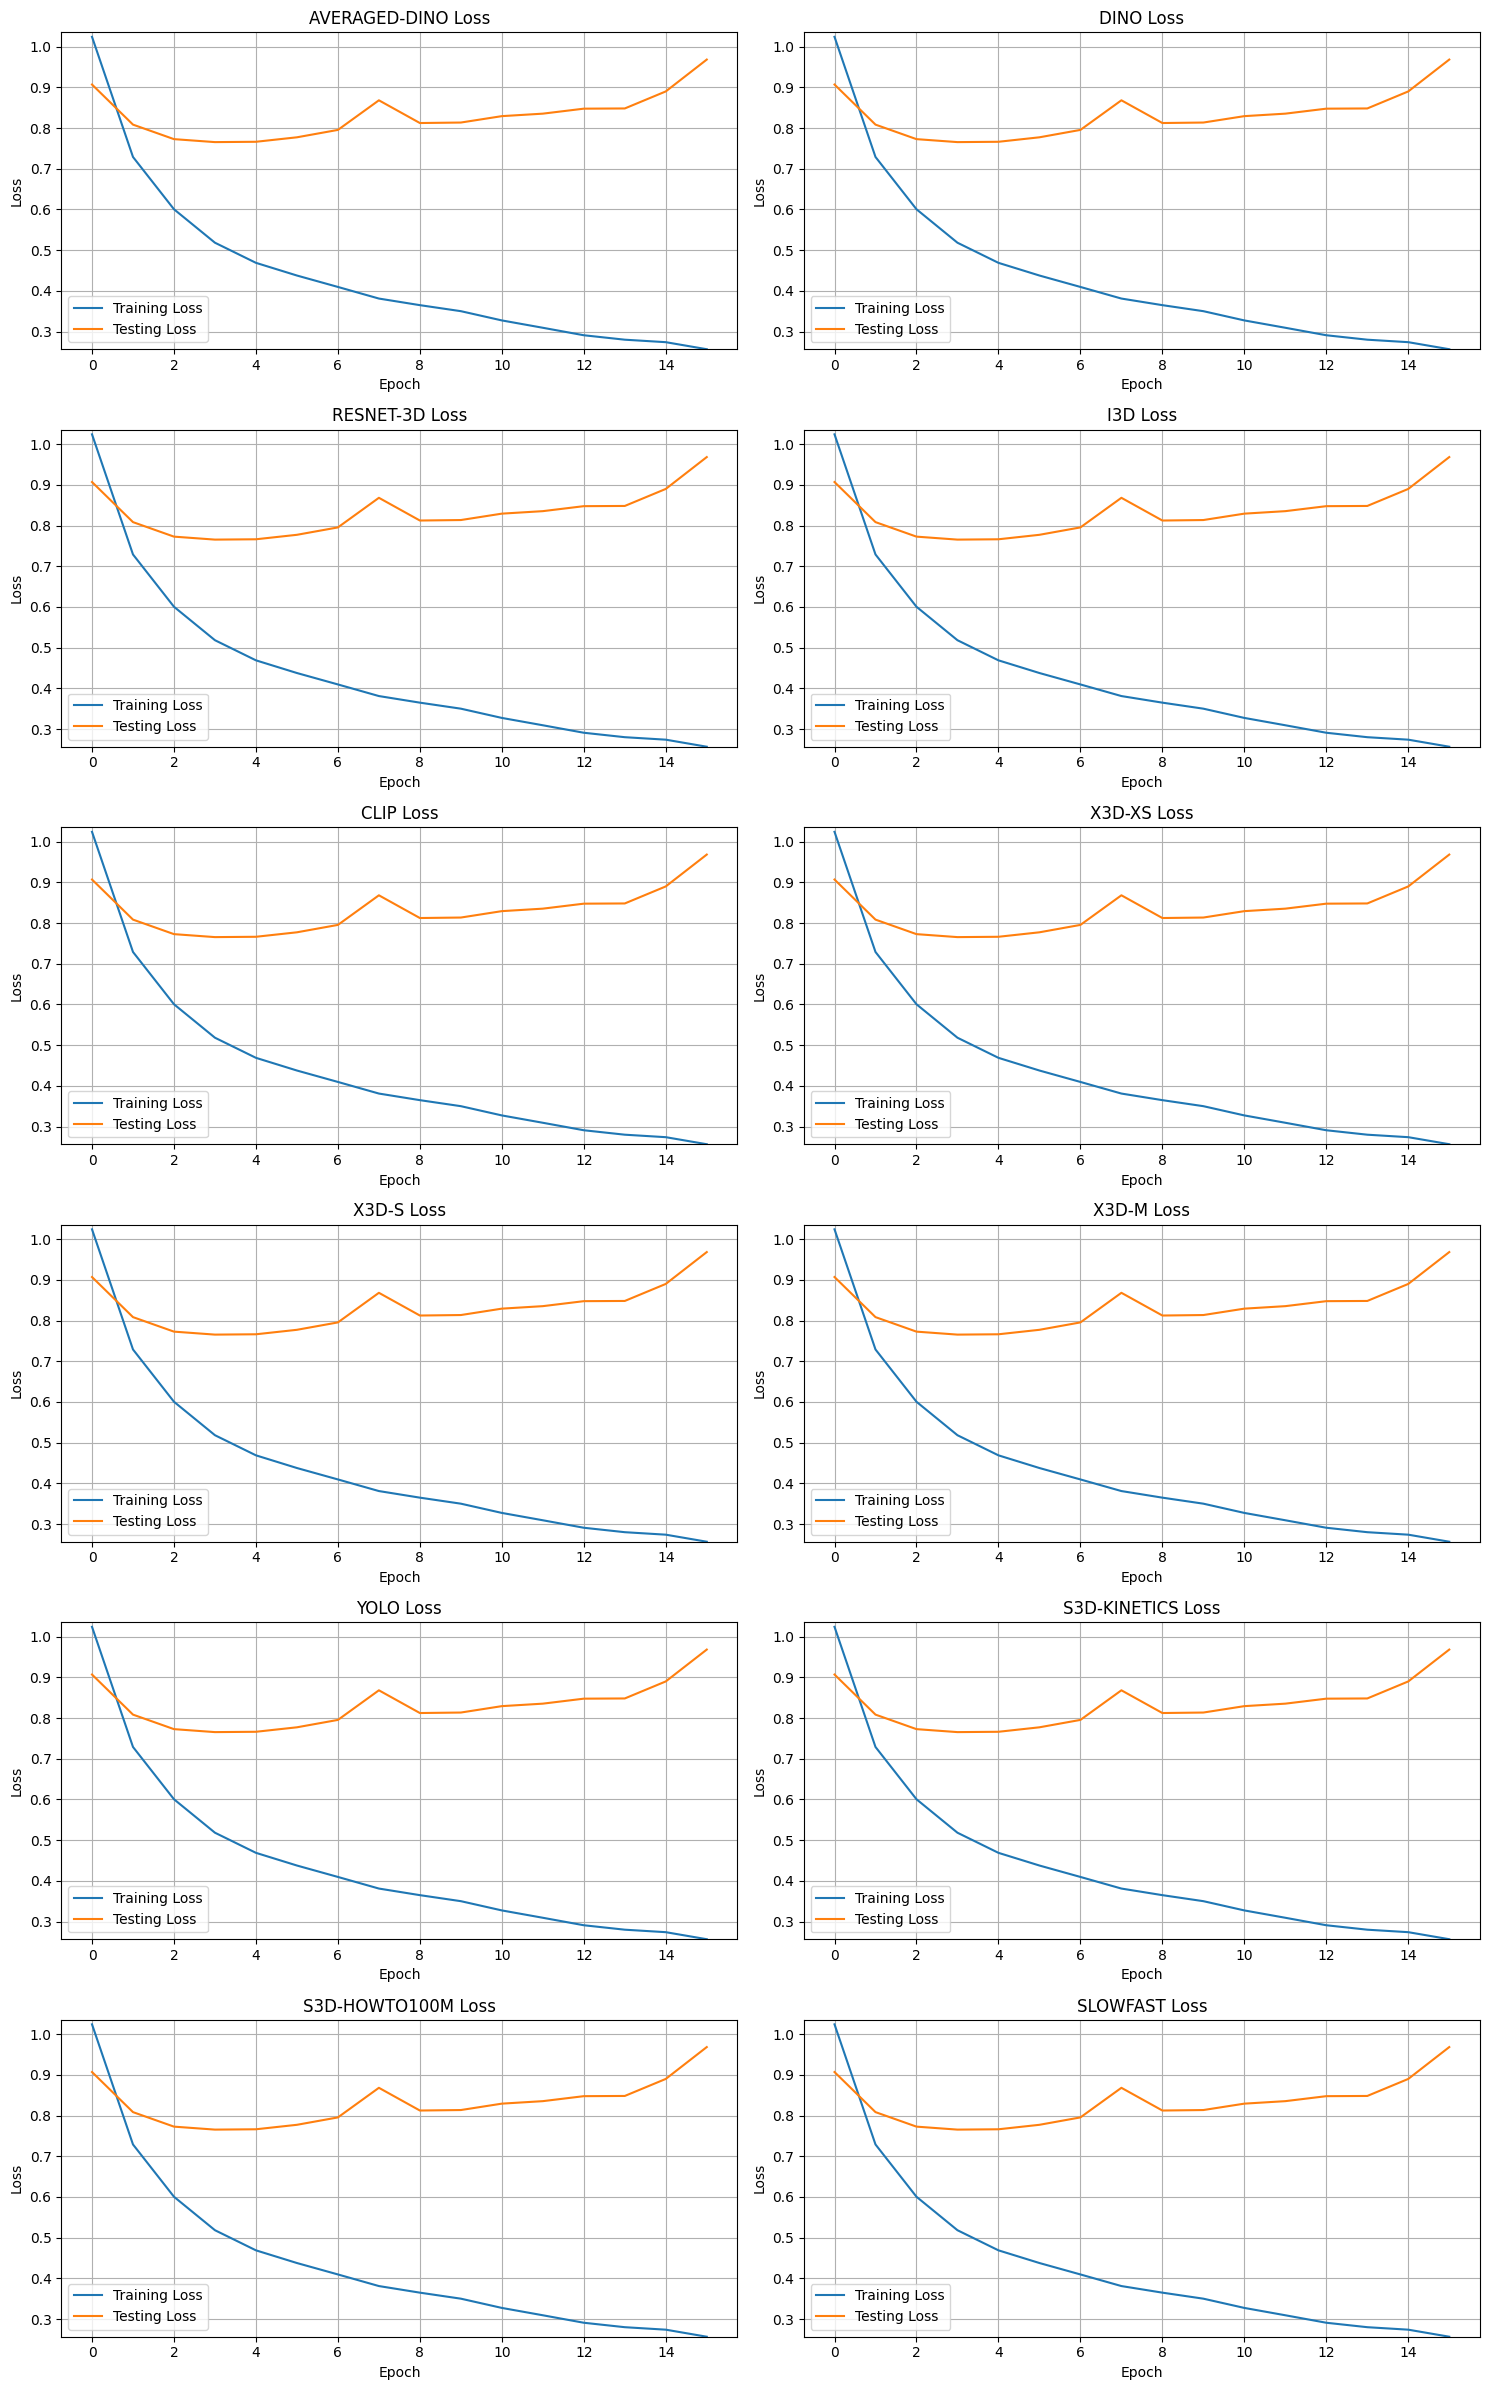

In [65]:
number_of_models = len(FEATURES_EXTRACTORS)

figure, axes = plt.subplots(nrows=(number_of_models+1)//2, ncols=2, figsize=(15, 4*((number_of_models+1)//2)))
axes = axes.flatten()

min_loss = float('inf')
max_loss = float('-inf')

for (history, best_training_accuracy, best_validation_accuracy, best_epoch), extractor in zip(histories, FEATURES_EXTRACTORS):
    name = extractor['name']
    min_loss = min(min_loss, 
                  min(history['training_loss']), 
                  min(history['testing_loss']))
    max_loss = max(max_loss, 
                   max(history['training_loss']), 
                   max(history['testing_loss']))

for idx, extractor in enumerate(FEATURES_EXTRACTORS):
    name = extractor['name']
    
    axes[idx].plot(history['training_loss'], label='Training Loss')
    axes[idx].plot(history['testing_loss'], label='Testing Loss')
    
    axes[idx].set_title(f'{name.upper()} Loss')
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel('Loss')
    axes[idx].legend()
    axes[idx].grid(True)
    
    axes[idx].set_ylim(min_loss, max_loss)

if number_of_models % 2 != 0:
    figure.delaxes(axes[-1])

plt.tight_layout()
plt.show()

In [66]:
best_scores = []

for index, extractor in enumerate(FEATURES_EXTRACTORS):
    model_training_stats = []
    model_testing_stats = []
    
    for fold_index, fold_histories in enumerate(folds_histories):
        history, best_training_accuracy, best_validation_accuracy, best_epoch = fold_histories[index]
        
        model_testing_stats.append(best_validation_accuracy)
        model_training_stats.append(best_training_accuracy)
        
    average_best_validation_score = np.mean(model_testing_stats)
    average_best_training_score = np.mean(model_training_stats)
    
    variance_best_training_score = np.var(model_training_stats)
    variance_best_validation_score = np.var(model_testing_stats)
    
    best_scores.append((average_best_training_score, average_best_validation_score, variance_best_training_score, variance_best_validation_score))
    
validation_accuracies = [score[1] * 100 for score in best_scores]
training_accuracies = [score[0] * 100 for score in best_scores]

In [67]:
for extractor, (average_best_training_score, average_best_validation_score, variance_best_training_score, variance_best_validation_score) in zip(FEATURES_EXTRACTORS, best_scores):
    print(f"[{extractor["name"]}]: {(average_best_validation_score * 100):.02f}% ± {(variance_best_validation_score * 100):.02f}%")

[averaged-dino]: 80.26% ± 0.05%
[dino]: 80.50% ± 0.06%
[resnet-3d]: 80.64% ± 0.04%
[i3d]: 80.93% ± 0.06%
[clip]: 80.18% ± 0.06%
[x3d-xs]: 80.42% ± 0.03%
[x3d-s]: 79.99% ± 0.04%
[x3d-m]: 80.37% ± 0.02%
[yolo]: 80.15% ± 0.04%
[s3d-kinetics]: 81.11% ± 0.04%
[s3d-howto100m]: 79.97% ± 0.02%
[slowfast]: 80.27% ± 0.05%


In [68]:
best_scores = []

for index, extractor in enumerate(FEATURES_EXTRACTORS):
    average_best_validation_score = 0
    average_best_training_score = 0
    
    for fold_index, fold_histories in enumerate(folds_histories):
        history, best_training_accuracy, best_validation_accuracy, best_epoch = fold_histories[index]
        
        average_best_validation_score += best_validation_accuracy
        average_best_training_score += best_training_accuracy
        
    average_best_validation_score /= NUMBER_OF_FOLDS
    average_best_training_score /= NUMBER_OF_FOLDS
    
    best_scores.append((average_best_training_score, average_best_validation_score))
    
validation_accuracies = [score[1] * 100 for score in best_scores]
training_accuracies = [score[0] * 100 for score in best_scores]

[len(model_names)]: 12
[len(markers)]: 12


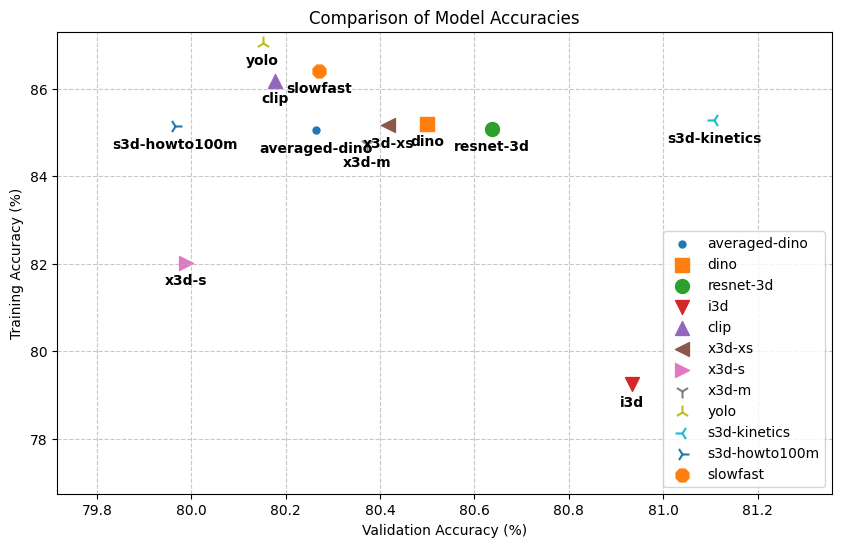

In [80]:
model_names = [extractor["name"] for extractor in FEATURES_EXTRACTORS]

# validation_accuracies = [best_scores["validation"][name] * 100 for name in model_names]
# training_accuracies = [best_scores["training"][name] * 100 for name in model_names]

markers = list(Line2D.markers.keys())
markers = markers[:len(model_names)]

print(f"[len(model_names)]: {len(model_names)}")
print(f"[len(markers)]: {len(markers)}")

plt.figure(figsize=(10, 6))

for i, (name, val_acc, train_acc, marker) in enumerate(zip(model_names, validation_accuracies, training_accuracies, markers)):
    plt.scatter(val_acc, train_acc, label=name, marker=marker, s=100)
    plt.text(val_acc, train_acc - 0.5, name, ha='center', fontsize=10, fontweight='bold')

plt.xlabel("Validation Accuracy (%)")
plt.ylabel("Training Accuracy (%)")

plt.title("Comparison of Model Accuracies")

plt.legend()

plt.grid(True, linestyle="--", alpha=0.7)

# TODO: the start and end of the y (training) and x (validation) axes should be the same
plt.xlim([min(validation_accuracies) - 0.25, max(validation_accuracies) + 0.25])
plt.ylim([min(training_accuracies) - 2.5, max(training_accuracies) + 0.25])

# min_val = min(min(training_accuracies), min(validation_accuracies))
# max_val = max(max(training_accuracies), max(validation_accuracies))
# plt.xlim([min_val, max_val])
# plt.ylim([min_val, max_val])

plt.show()

In [82]:
# TODO: do data augmentation.
# TODO: try merging multiple features to construct an even better model.

In [ ]:
# TODO: try using an LSTM
# TODO: try incorporating priors such as the average duration, etc

<div class="alert alert-warning">

**Confusion Matrices:**

</div>

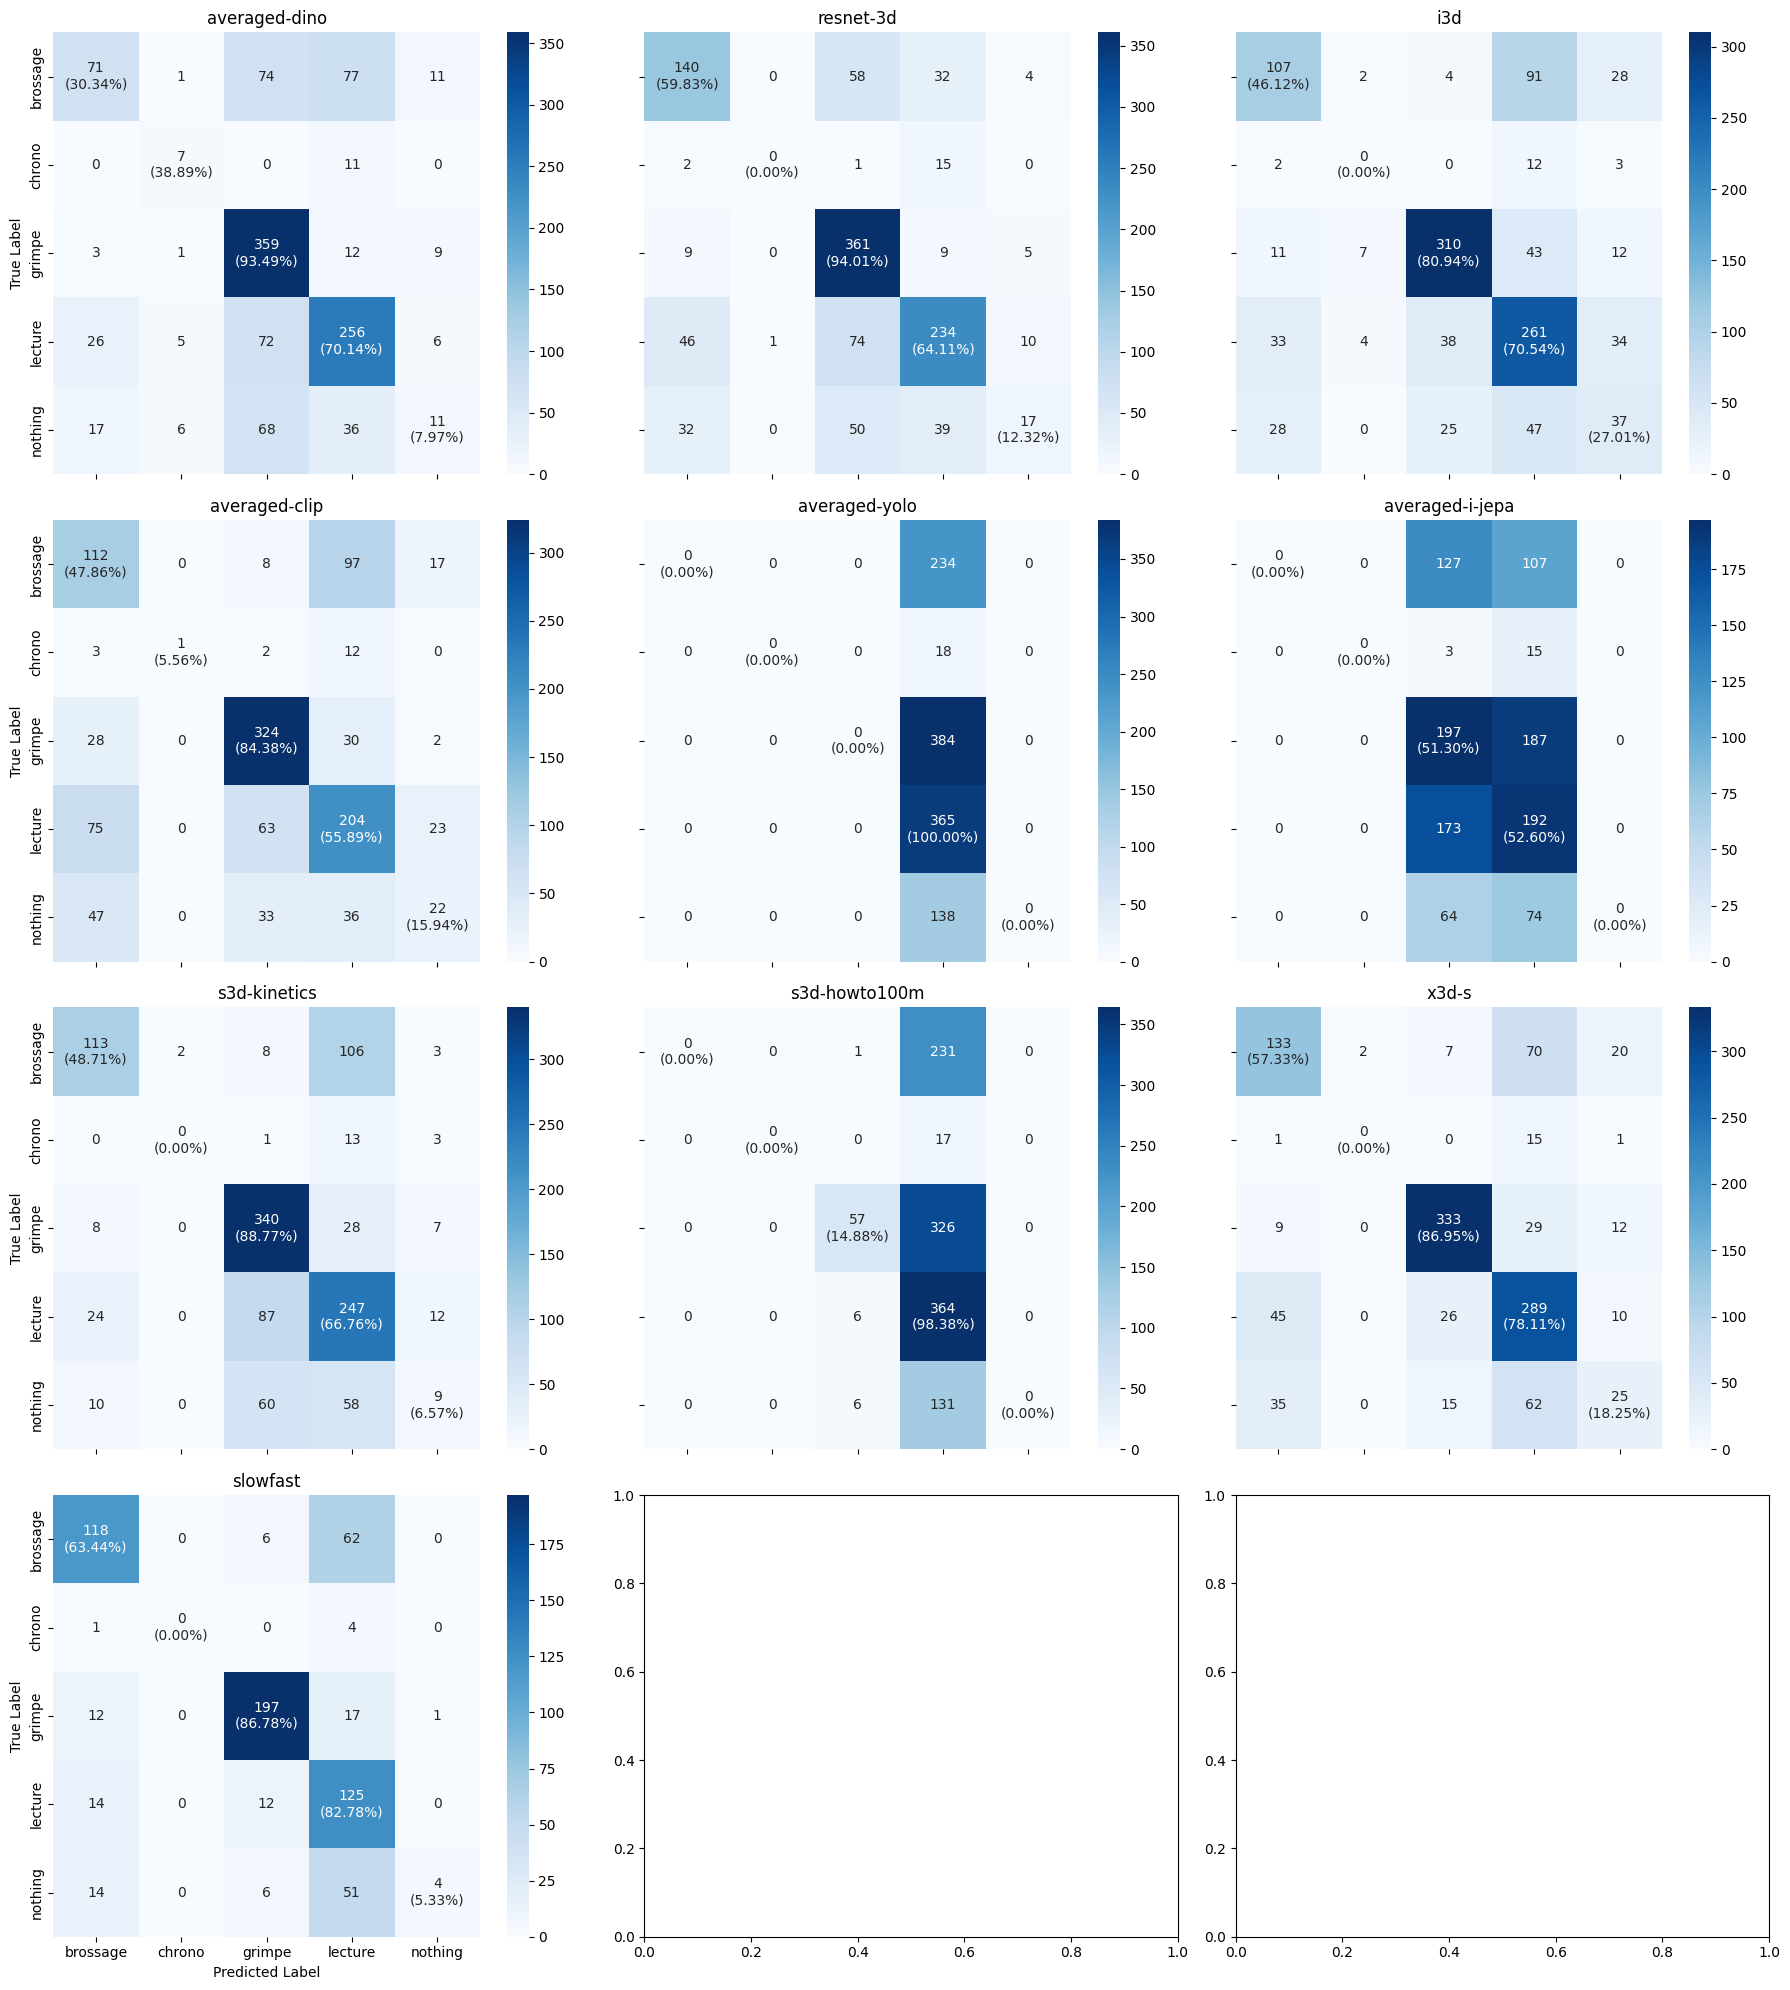

In [ ]:
# Function to compute per-class accuracy
def compute_per_class_accuracy(conf_matrix):
    return conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Store per-class accuracies
per_class_accuracies = {}

# Determine grid size for subplots
num_models = len(FEATURES_EXTRACTORS)
cols = min(3, num_models)  # Maximum 3 columns for readability
rows = (num_models + cols - 1) // cols  # Compute required rows

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = np.array(axes)  # Ensure axes is always a NumPy array
axes = axes.flatten()  # Flatten in case of a single row

for idx, (classifier, extractor, training_dataset, testing_dataset) in enumerate(
    zip(classifiers, FEATURES_EXTRACTORS, cached_datasets["training"], cached_datasets["testing"])
):
    model_name = extractor["name"]

    # Get model predictions & ground truth labels
    all_preds = []
    all_labels = []

    classifier.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for inputs, labels in torch.utils.data.DataLoader(testing_dataset, batch_size=32, shuffle=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = classifier(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Compute per-class accuracy
    per_class_acc = compute_per_class_accuracy(conf_matrix)
    per_class_accuracies[model_name] = per_class_acc

    # Modify matrix values: put per-class accuracy on diagonal
    conf_matrix_display = conf_matrix.astype(str)  # Convert to string for annotations
    for i in range(len(per_class_acc)):
        conf_matrix_display[i, i] = f"{conf_matrix[i, i]}\n({per_class_acc[i]:.2%})"

    # Plot the confusion matrix in the corresponding subplot
    ax = axes[idx]
    sns.heatmap(conf_matrix, annot=conf_matrix_display, fmt="", cmap="Blues",
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=ax)

    # Only show x-axis label for bottom row
    if idx // cols == rows - 1:
        ax.set_xlabel("Predicted Label")
    else:
        ax.set_xlabel("")
        ax.set_xticklabels([])

    # Only show y-axis label for leftmost column
    if idx % cols == 0:
        ax.set_ylabel("True Label")
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])

    ax.set_title(f"{model_name}")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

<div class="alert alert-warning">

**Segmentation Visualization:**

</div>

---

### About Dino

<div class="alert alert-info">

**Dino Model Card:** https://github.com/facebookresearch/dinov2/blob/main/MODEL_CARD.md

**Dino for Video Classification:** https://github.com/facebookresearch/dinov2/issues/16

**Note on UniformTemporalSubSample Size:** Increasing it will give better results but increase loading time. https://github.com/facebookresearch/dinov2/issues/16#issuecomment-1521403076

</div>

<div class="alert alert-warning">

**`patchtokens`** are the image token / patches embeddings after they have been passed through the network and the 324 is here because we have a total of 324 patches.

**`clstoken`** is the cls token that is supposed to contain all the relevant information about the image.

**`regtokens`** are regularization tokens and they only help improve feature diversity and representation during training. Only 4 are used in this model.

**`prenorm`** is represent the combined tokens before the layer normalization (1 [CLS Token] + 4 Regularization Tokens + 324 Patch Tokens = 329).

The 768 is the patch embedding size that is used by Deno. And the 16 that keeps reappearing is the batch size since we are using a sample of 16 frames.

```bash
[features.keys()]: dict_keys(['x_norm_clstoken', 'x_norm_regtokens', 'x_norm_patchtokens', 'x_prenorm', 'masks'])
[number_of_patches]: 324
[x_norm_clstoken]: torch.Size([16, 768])
[x_norm_regtokens]: torch.Size([16, 4, 768])
[x_norm_patchtokens]: torch.Size([16, 324, 768])
[x_prenorm]: torch.Size([16, 329, 768])
[masks]: None
```

</div>

<div class="alert alert-success">

**Questions**
- [ ] Why are we using the last hidden state rather than the last memory cell or output ?

</div>

---

### About I-Jepa

<div class="alert alert-warning">


- [ ] **Checkout** [This Site](https://paperswithcode.com/sota/action-classification-on-kinetics-600?p=video-swin-transformer) for a leaderboard on video classification task.

- [ ] Experiment with features from I-Jepa
- [ ] Experiment with features from VideoMAE-ViT-H/16; OmniMAE-ViT-H/16 and VideoMAEv2-ViT-g/14 and other ViT based models for features extraction.
- [ ] Experiment on fine tuning ViT for a specific task using some unlabelled videos or reinforcement learning.
- [ ] Try to perform some sort of clustering and visualizations on using Umap and PCA on these extracted features on different models, do this for features from different models such as ViT, resnet, Video CNNs, etc.

</div>

<div class="alert alert-warning">

- [ ] Is this [Repository](https://github.com/kylemin/S3D) the same as the one we took the S3D model from ?

</div>

<div class="alert alert-info">

**Introduction Video About Image-Jepa:** https://www.youtube.com/watch?v=6bJIkfi8H-E

**V-Jepa Paper:** [Here](https://scontent-lhr8-2.xx.fbcdn.net/v/t39.2365-6/427986745_768441298640104_1604906292521363076_n.pdf?_nc_cat=103&ccb=1-7&_nc_sid=3c67a6&_nc_ohc=G-D4kApr8TQQ7kNvgFSoEBh&_nc_oc=AdiZo1b5QaDaQaf0hctrozKJ2vjIp_iQvUZxArm_8k3ngVZNVLtltyVFidEIN-Njt9g&_nc_zt=14&_nc_ht=scontent-lhr8-2.xx&_nc_gid=AzzCS9ed8AZ-B2iLuVB7EE0&oh=00_AYB3kfkI_sVH0UVTrzunG99_ThmOVCNN7sRu9q9XS7nAPw&oe=67BCDFF1).

</div>

### About YOLO

<div class="alert alert-info">

`keypoints = torch.tensor(result.keypoints[0].xyn)`. the `xyn` gives the normalized version of the `xy` keypoints, the "n" stands for "normalized".

</div>